Available Features in Original Dataset:
['Campaign_Type', 'Target_Audience', 'Duration', 'Ad_Type', 'Conversion_Rate', 'Ad_Budget', 'Reach', 'Clicks', 'Impressions', 'Date']
Available Features After Preprocessing:
['Campaign_Type', 'Duration', 'Ad_Budget', 'Reach', 'Clicks', 'Impressions', 'Year', 'Month', 'Day', 'Ad_Type_Facebook', 'Ad_Type_Google Ads', 'Ad_Type_Instagram', 'Ad_Type_Website', 'Ad_Type_YouTube']
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       240
           1       0.96      0.73      0.83       240
           2       0.89      0.78      0.83       240
           3       0.92      0.81      0.86       240

    accuracy                           0.82       960
   macro avg       0.86      0.82      0.83       960
weighted avg       0.86      0.82      0.83       960


Top 10 Feature Importance with Standard Deviation:
               Feature  Importance       Std
1            Ad_Budget    0.1

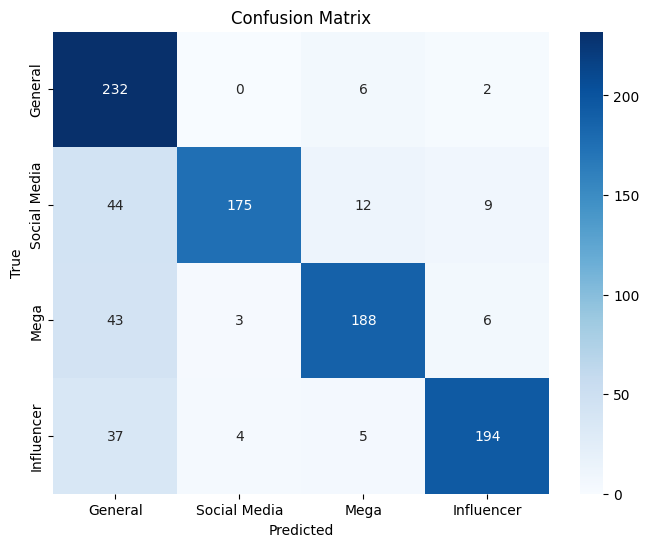

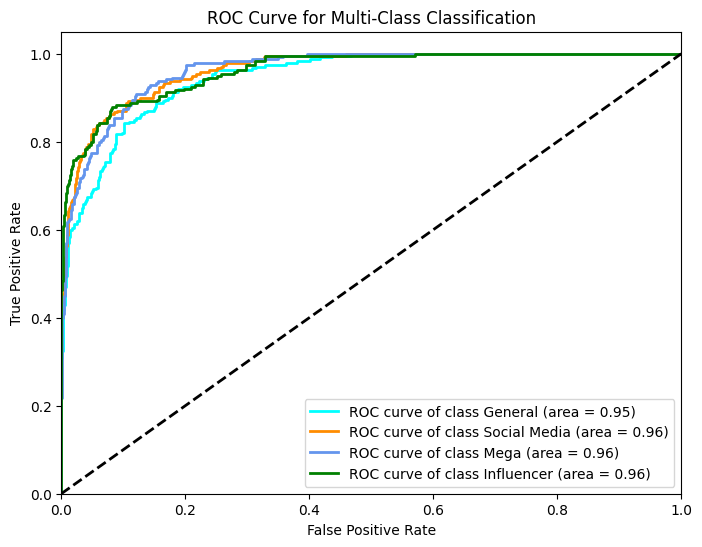

<ipython-input-1-e986d0d1555a>:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")


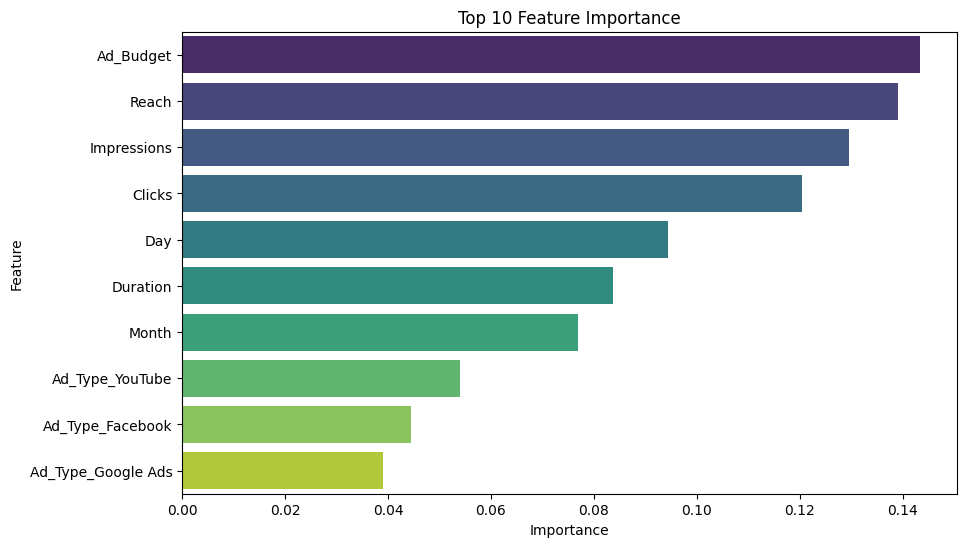

<ipython-input-1-e986d0d1555a>:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_before, palette="Set2")
<ipython-input-1-e986d0d1555a>:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_after, palette="Set2")


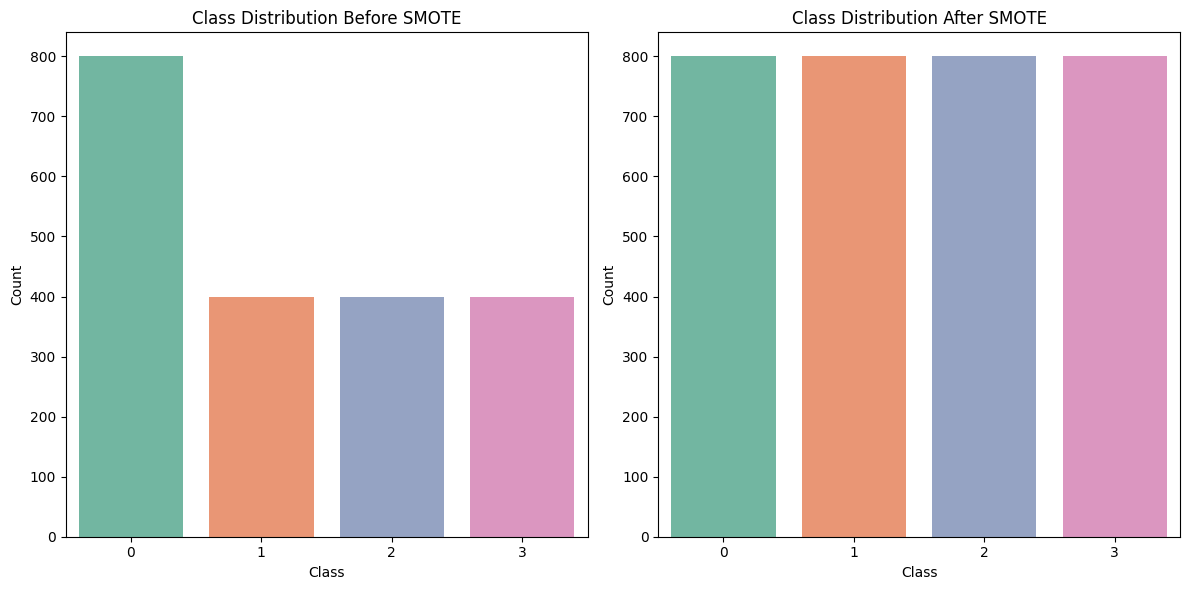

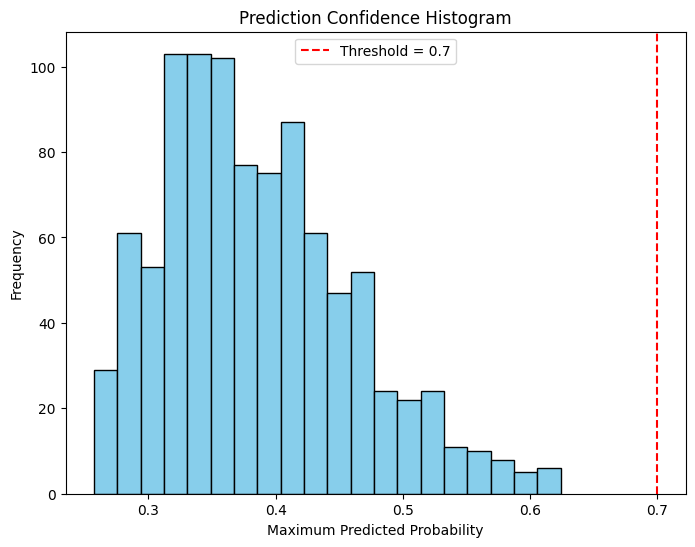

['standard_scaler.pkl']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import joblib

# Load the dataset
data = pd.read_csv('Final_Dataset.csv')

print("Available Features in Original Dataset:")
print(data.columns.tolist())

# Drop unnecessary columns
data = data.drop(['Conversion_Rate', 'Target_Audience'], axis=1)

# Convert 'Date' to datetime and extract useful features
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Drop the original 'Date' column
data = data.drop('Date', axis=1)

# Extract numeric part from the 'Duration' column and convert to integer
data['Duration'] = data['Duration'].str.extract('(\d+)').astype(int)

# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_columns = ['Ad_Type']
encoded_cats = encoder.fit_transform(data[categorical_columns])
encoded_cat_columns = encoder.get_feature_names_out(categorical_columns)
data = data.drop(categorical_columns, axis=1)
data[encoded_cat_columns] = encoded_cats

# Define features and target
X = data.drop('Campaign_Type', axis=1)
y = data['Campaign_Type']

# Encode target variable
y_encoded = pd.factorize(y)[0]

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42, k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Scale numeric features
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_resampled[numeric_features] = scaler.fit_transform(X_resampled[numeric_features])

# Define a smaller parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

print("Available Features After Preprocessing:")
print(data.columns.tolist())

# Train the model
grid_search.fit(X_resampled, y_resampled)

# Get the best model
best_model = grid_search.best_estimator_

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate feature importance with uncertainty
importances = best_model.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in best_model.estimators_
], axis=0)

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances,
    "Std": std
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Feature Importance with Standard Deviation:")
print(feature_importance_df.head(10))

# Print campaign_prediction type mapping
print("\nCampaign Type Mapping:")
print(dict(enumerate(data['Campaign_Type'].unique())))

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Visualization Functions

# 1. Confusion Matrix Heatmap
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 2. ROC Curve for Multi-Class Classification
def plot_roc_curve(y_true, y_pred_proba, class_names):
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = y_true_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Multi-Class Classification")
    plt.legend(loc="lower right")
    plt.show()

# 3. Feature Importance Bar Plot
def plot_feature_importance(feature_importance_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10), palette="viridis")
    plt.title("Top 10 Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# 4. Class Distribution Before and After SMOTE
def plot_class_distribution(y_before, y_after, title_before, title_after):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.countplot(x=y_before, palette="Set2")
    plt.title(title_before)
    plt.xlabel("Class")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_after, palette="Set2")
    plt.title(title_after)
    plt.xlabel("Class")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

# 5. Prediction Confidence Histogram
def plot_confidence_histogram(y_pred_proba, confidence_threshold):
    max_proba = np.max(y_pred_proba, axis=1)
    plt.figure(figsize=(8, 6))
    plt.hist(max_proba, bins=20, color="skyblue", edgecolor="black")
    plt.axvline(x=confidence_threshold, color="red", linestyle="--", label=f"Threshold = {confidence_threshold}")
    plt.title("Prediction Confidence Histogram")
    plt.xlabel("Maximum Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Plot Confusion Matrix
class_names = list(data['Campaign_Type'].unique())
plot_confusion_matrix(y_test, y_pred, class_names)

# Plot ROC Curve
plot_roc_curve(y_test, y_pred_proba, class_names)

# Plot Feature Importance
plot_feature_importance(feature_importance_df)

# Plot Class Distribution Before and After SMOTE
plot_class_distribution(y_encoded, y_resampled, "Class Distribution Before SMOTE", "Class Distribution After SMOTE")

# Plot Prediction Confidence Histogram
confidence_threshold = 0.7
plot_confidence_histogram(y_pred_proba, confidence_threshold)

# Save the model, encoder, and scaler
joblib.dump(best_model, 'campaign_type_model.pkl')
joblib.dump(encoder, 'one_hot_encoder.pkl')
joblib.dump(scaler, 'standard_scaler.pkl')